**[Oreum Industries](https://oreum.io/) Reference Project, 2024Q3**

---

# 000_Intro.ipynb

### Oreum Reference - Copula Regression `oreum_copula`

Demonstrate Bayesian Copula Regression Modelling using Bayesian inference and a Bayesian workflow, specifically using 
the `pymc` & `arviz` ecosystem.

This **Intro** can also be used for verbal presentation and discussion purposes, ideally followed by a deeper technical 
walkthrough of the project in a long-form style. Because this project is a reference, it contains huge amounts of detail 
which is not worthwhile to summarise too much. 

The interested reader should refer to the project notebooks where we evaluate the behaviour and performance of the 
models throughout the workflows, including several state-of-the-art methods unavailable to conventional max-likelihood 
/ machine-learning models.

[PDF version](000_Intro.pdf)

[Oreum Industries: Technical Resources](https://github.com/oreum-industries)

<a href='https://oreum.io'><img src='../assets/img/Oreum_wordmark_black_right_aligned_S.png' width='300px' style="float: right;"/></a><div style="clear:both"/>

---

## _What is Copula Regression?_

We seek to create _principled_ models that provide explanatory inference and predictions of Marginal distributions $M$
that are jointly coupled by a Latent Copula $C$, using quantified uncertainty to support real-world decision-making.

<img src='../plots/000_jointplot_corr.png' width='480px'/>

**Motivation:**

+ A classic use-case for this model architecture (in the 2-dimensional setting) is insurance claims frequency and severity
+ The `frequency` of claims and the `severity` of each claim each have marginal distributions and a natural covariance 
  $\Sigma$ between marginals $M_{0}, M_{1}$
+ The joint product `frequency * severity = Loss Cost` i.e. the dollar value of insurable losses
+ If we use a naive model that doesn't account for the covariance between `frequency` and `severity`, then the model 
  predictions for `Loss Cost` can be hugely wrong!

<img src='../plots/000_jointplot_corr.png' width='360px'/>


**Demonstration:**

+ In this notebook:
  + We create a small synthetic dataset of observations of two marginals $M_{0}, M_{1}$ which have 
    covariance $\Sigma$, and also (because we can) a version of the marginals $M_{0x}, M_{1x}$ without covariance
  + We compare the resulting values of the joint product $y = M_{0} * M_{1}$ vs $y = M_{0x} * M_{1x}$ and see that impact
    of ignoring the covariance is substantial.
+ In the rest of the reference guide:
  + We create a series of principled copula models using advanced architectures and Bayesian inference to fit to the 
    data and estimate the covariance on $M_{0}, M_{1}$
  + The first model is naive and ignores the covariance, the final model is very sophisticated and estimates the covariance
  + We demonstrate **a substantial 32 percentage-point improvement in model accuracy** when using a copula-based model
  + This correct estimation would likely make the difference between profitable pricing / accurate reserving, or greatly loss-making business over a portfolio.

**General project approach**

The emphasis in this project is to build a variety of models of increasing sophistication and demonstrate their usage. 
We strike a balance between building up concepts & methods vs practical application & worked examples in a `pymc`-based 
Bayesian workflow.

We don't focus on specific analysis of the dataset, nor try to infer too much. The dataset is simply a good substrate on
which to learn and demonstrate the variety of model architectures used herein.

We evaluate the behaviour and performance of the models throughout the workflows, including several state-of-the-art 
methods unavailable to conventional max-likelihood / machine-learning models

**This series of Notebooks covers**

+ `000_Intro.ipynb`: Orientiation and fundamental concepts 
+ `100_ModelA0.ipynb`: Core (naive) architecture: Create priors, marginal likelihoods, but no copula
+ `101_ModelA1.ipynb`: Partial architecture (extends ModelA0): Include Gaussian copula (w/ Jacobian adjustment), and several technical innovations to let `pymc` work with the transformations
+ `102_ModelA2.ipynb`: Full architecture (extends ModelA1): Include Jacobian Adjustment on transformed observations

**In this Notebook**

We dive straight into **Orientation** and **Fundamental General Abstractions** with a simple real-world 
observational censored dataset, and then go on to demonstrate the theory and usage of an increasing sophistication of models.


## Contents

+ [Setup](#Setup)

+ [Preamble: Why Bayes?](#Preamble:-Why-Bayes?)

+ [1. Orientation: Copula Functions and Their Behaviour](#1.-Orientation:-Copula-Functions-and-Their-Behaviour)

+ [2. Brief Technical Summary: The Copula Model designed in this Project](#2.-Brief-Technical-Summary:-The-Copula-Model-designed-in-this-Project)

---

---

# Setup

### Imports

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from oreum_core import eda
from pyprojroot.here import here

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))

from engine import logger
from synthetic.create_copula import CopulaBuilder

# autoreload local modules to allow local dev
%load_ext autoreload
%autoreload 2
import warnings  # noqa
warnings.simplefilter(action='ignore', category=FutureWarning)  # noqa
warnings.simplefilter(action='ignore', category=UserWarning)  # noqa
import seaborn as sns

### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

log = logger.get_logger('000_Intro', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

### Local Functions and Global Vars

In [3]:
RSD = 42
RNG = np.random.default_rng(seed=RSD)

### Data Connections

In [4]:
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))

---

---

# Preamble: Why Bayes?

## We gain massive advantage by using a Bayesian Framework

We specifically use [**Bayesian Inference**](https://betanalpha.github.io/assets/case_studies/modeling_and_inference.html)
rather than Frequentist Max-Likelihood methods for many reasons, including:

|  | Bayesian Inference | Frequentist Max-Likelihood   | 
| --- | --- | ---|
| **General formulation** $\rightarrow$<br/> **Desirable Trait** $\downarrow$ | _Bayes' Rule_ $$\underbrace{P(\hat{\mathcal{H}}\|D)}_{\text{posterior}} = \frac{\overbrace{P(D\|\mathcal{H})}^{\text{likelihood}} \cdot \overbrace{P(\mathcal{H})}^{\text{prior}}}{\underbrace{P(D)}_{\text{evidence}}} $$ | _MLE_ $$\hat{\mathcal{H}}^{\text{MLE}} \propto \arg\max_{\mathcal{H}} P(D\|\mathcal{H})$$ |
| **_Principled_ model structure represents hypothesis about the data-generating process** | **Very strong** <br/> Can build bespoke arbitrary and hierarchical structures of parameters to map to the real-world data-generating process. | **Weak** <br/> Can only state structure under strict limited assumptions of model statistical validity. |
| **Model parameters and their initial values represent domain expert knowledge** | **Very strong** <br/>Marginal prior distributions represent real-world probability of parameter values before any data is seen. | **Very weak** <br/> No concept of priors. Lack of joint probability distribution can lead to discontinuities in parameter values. |
| **Robust parameter fitting process** | **Strong** <br/> Estimate full joint posterior probability mass distribution for parameters - more stable and representative of the expectation for the parameter values. Sampling can be a computationally expensive process. | **Weak** <br/> Estimate single-point max-aposterioi-likelihood (density) of  parameters - this can be far outside the probability mass and so is prone to overfitting and only correct in the limit of infinite data. But optimization method can be computationally cheap. |
| **Fitted parameters have meaningful summary statistics for inference** | **Very strong** <br/>Full marginal probability distributions can be interpreted exactly as probabilities. | **Weak** <br/>Point estimates only have meaningful summary statistics under strict limited assumptions of model statistical validity. |


continues ...

... continued

| Desirable Trait | Bayesian Inference | Frequentist Max-Likelihood |
| --- | --- | ---|
| **Robust model evaluation process** | **Strong** <br/>Use entire dataset, evaluate via Leave-One-Out Cross Validation (best theoretically possible). | **Weak** <br/> Cross-validation rarely seen in practice, even if used, rarely better than 5-fold CV. Simplistic method can be computationally cheap. |
| **Predictions made with quantified variance** | **Very strong** <br/>Predictions made using full posterior probability distributions, so predictions have full empirical probability distributions. | **Weak** <br/>Predictions using point estimates can be bootstrapped, but predictions only have interpretation under strict limited assumptions of model validity. |
| **Handle imbalanced, high cardinality & hierarchical factor features** | **Very strong** <br/>Can introduce partial-pooling to automatically balance factors through hierarchical priors. | **Weak** <br/>Difficult to introduce partial-pooling (aka mixed random effects) without affecting strict limited assumptions of model validity. |
| **Handle skewed / multimodal / extreme value target variable** | **Very strong** <br/>Represent the model likelihood as any arbitrary probability distribution, including mixture (compound) functions e.g. a zero-inflated Weibull. | **Weak** <br/>Represent model likelihood with a usually very limited set of distributions. Very difficult to create mixture compound functions. |
| **Handle small datasets** | **Very strong** <br/>Bayesian concept assumes that there is a probable range of values for each parameter, and that we evidence our prior on any amount of data (even very small counts). | **Very weak** <br/>Frequentist concept assumes that there is a single true value for each parameter and that we only discover that value in the limit (of infinite observations). |
| **Automatically impute missing data** | **Very strong** <br/>Establish a prior for each datapoint, evidence on the available data within the context of the model, to automatically impute missing values. | **Very weak** <br/>No inherent method. Usually impute as a pre-processing step with weak non-modelled methods. |

## Practical Implementations of Bayesian Inference

We briefly referenced _Bayes Rule_ above, which is a useful mnemonic when discussing Bayesian Inference, but in practice
the crux of putting these advanced statistical techniques into practice is estimating the evidence $P(D)$ i.e. the 
probability of observing the data that we use to evidence the model

$$
\begin{aligned}
\underbrace{P(\hat{\mathcal{H}}|D)}_{\text{posterior}} &= 
    \frac{\overbrace{P(D|\mathcal{H})}^{\text{likelihood}} \cdot 
    \overbrace{P(\mathcal{H})}^{\text{prior}}}{\underbrace{P(D)}_{\text{evidence}}} \\
\\
\text{...where:} \\
\\
P(D) &\sim \int_{\Theta} P(D, \theta)\ d\theta \\
\end{aligned}
$$

This joint probability $P(D, \theta)$ of data $D$ and parameters $\theta$ requires an almost impossible-to-solve integral
over parameter-space $\Theta$. Rather than attempt to calculate that integral, we do something that sounds far more 
difficult, but given modern computing capabilities is actually practical.

### We use a Bleeding-edge MCMC Toolkit for Bayesian Inference: `pymc` & `arviz`

We use **Markov Chain Monte-Carlo (MCMC)** sampling to take a series of _ergodic_, _partly-reversible_, _partly-randomised_ 
samples of model parameters $\theta$, and at each step compute the ratio of log-likelihoods $\log P(D|\mathcal{H})$ 
between a starting position (current values) $\theta_{p0}$ and proposed "sampled" position $\theta_{p}$ in parameter 
space, so as to reduce that log-likelihood (whilst exploring the parameter space). 

This results in a posterior estimate $P(\hat{\theta}|D)$:

$$
\begin{aligned}
P(\hat{\theta}|D) &\sim 
    \frac{\overbrace{P(D|\theta_{p})}^{\text{likelihood @ proposal}} \cdot \overbrace{P(\theta_{p})}^{\text{prior @ proposal}}}
    {\underbrace{P(D|\theta_{p0})}_{\text{likelihood @ current}} \cdot \underbrace{P(\theta_{p0})}_{\text{prior @ current}}}
\end{aligned}
$$

This is the heart of MCMC sampling: for detailed practical explanations see [Betancourt, 2021](https://betanalpha.github.io/assets/case_studies/sampling.html), [Carroll, 2019](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/), and [Tweicki, 2015](https://twiecki.io/blog/2015/11/10/mcmc-sampling/)

We use the bleeding-edge [`pymc`](https://www.pymc.io/welcome.html) and [`arviz`](https://python.arviz.org/en/stable/)
Python packages to provide the full Bayesian toolkit that we require, including advanced sampling, probabilistic programming, 
statistical inferences, model evaluation and comparison, and more.

<img src='../assets/img/logos.png' width='600px'/>

---

---

# 1. Orientation: Copula Functions and Their Behaviour

## 1.1 Create Synthetic Copula Dataset

We can learn a lot by creating a synthetic copula dataset using a "forward-pass":

1. Start with random data $C$ sampled from the PDF of a Latent Copula function $\square_{\mathfrak{C}}$ with 2-dimensions
$$(C_{0}, C_{1}) \sim \square_{\mathfrak{C}}$$

2. Transform each dimension of the coupled data through the CDF of the copula function $\Phi_{\mathfrak{C}}$ to yield 
   data distributed according to a Latent Uniform distribution $U$
$$(U_{0}, U_{1}) = \Phi_{\mathfrak{C}}(C_{0}, C_{1})$$

3. Transform each dimension of now-uniform data through the Inverse CDF of our chosen marginal distribution 
   $\Phi^{-1}_{\mathfrak{M}}$ to yield data distributed according to "observed" Marginal distribution(s) $M$
$$(M_{0}, M_{1}) = \Phi^{-1}_{\mathfrak{M}}(U_{0}, U_{1})$$

In the following slides we'll plot the distributions and describe the transformations. Also see project class
`synthetic.create_copula.CopulaBuilder` for details

Note we create $60$ observations split into 2 sets: $50$ for `train` (in-sample) and $10$ for `holdout` (out-of-sample)

In [5]:
cb = CopulaBuilder()
df_all = cb.create(nobs=60)
cb.ref_vals

{'c_r': -0.7,
 'c_cov': array([[ 1. , -0.7],
        [-0.7,  1. ]]),
 'm0_kind': 'lognorm',
 'm1_kind': 'lognorm',
 'm0_params': {'mu': 0.2, 'sigma': 0.5},
 'm1_params': {'mu': 2.0, 'sigma': 1.0}}

In [6]:
perm = RNG.permutation(df_all.index.values)
df_train = df_all.loc[perm[:50]]
df_holdout = df_all.loc[perm[50:]]

In [7]:
eda.describe(df_train, nobs=0, get_counts=False)

,dtype,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,
index: oid,object,50,i028,1,NaN,NaN,NaN,i000,NaN,NaN,NaN,i059
c0,float64,NaN,NaN,NaN,-1.63,-0.03,0.79,-2.13,-0.64,-0.06,0.68,1.42
c1,float64,NaN,NaN,NaN,-1.85,-0.04,0.86,-2.12,-0.5,0.06,0.56,1.82
u0,float64,NaN,NaN,NaN,24.61,0.49,0.26,0.02,0.26,0.48,0.75,0.92
u1,float64,NaN,NaN,NaN,24.84,0.5,0.27,0.02,0.31,0.52,0.71,0.97
m0,float64,NaN,NaN,NaN,64.71,1.29,0.5,0.42,0.89,1.19,1.72,2.49
m1,float64,NaN,NaN,NaN,493.00,9.86,8.25,0.89,4.47,7.84,12.93,45.47
c0x,float64,NaN,NaN,NaN,-5.38,-0.11,0.91,-2.62,-0.58,-0.0,0.34,1.89
c1x,float64,NaN,NaN,NaN,-5.52,-0.11,1.0,-1.99,-0.62,-0.21,0.54,2.46


'Shape: (50, 13), Memsize 0.0 MB'

## 1.2 Visualise the Synthetic Observations

### 1.2.1 View the Latent Copula (an MvN)

In this forward-pass to create the synthetic data, we firstly create $50$ observations of
of a 2-dimensional Multivariate Normal distribution with covariance $\Sigma$

$$
\begin{aligned}
(C_{0}, C_{1}) &\sim \square_{\mathfrak{C}} \\
            &\sim \text{MultivariateNormal}(\mu, \Sigma, \text{shape}=2)
\end{aligned}
$$

This forms our Latent Copula (a Gaussian), and this is where we could get creative and use any number of alternative
copula functions from the literature (e.g. Clayton, Frank, Gumbel, etc) or even create our own: the copula marginals
dont have to be the same distribution

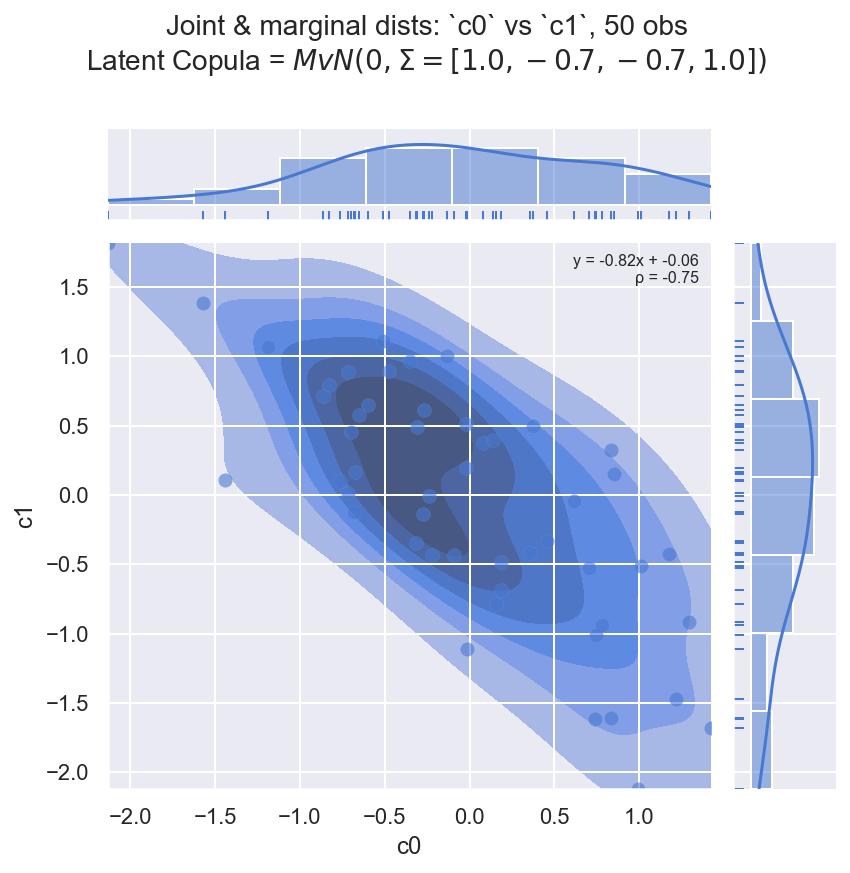

In [8]:
f = eda.plot_joint_numeric(data=df_train, ft0='c0', ft1='c1', kind='kde+scatter', 
            txtadd=f'Latent Copula = $MvN(0, \\Sigma={cb.ref_vals["c_cov"].flatten().tolist()})$')

**Observe:**

+ Note the standard `Normal(0,1)` scaling on the marginals
+ Note the empirically-observed correlation $\rho \approx -0.7$ as defined in `c_cov`

### 1.2.2 View the Uniform-Transformed Marginals

In this forward-pass to create the synthetic data, next we pass each dimension of the Latent Copula $C$ through the 
CDF of it's own function $\Phi_{\mathfrak{C}}$ to get a Latent Uniform distribution $U$

$$
\begin{aligned}
(U_{0}, U_{1}) &= \Phi_{\mathfrak{C}}(C_{0}, C_{1}) \\
            &= \text{NormalCDF}(C_{0}, C_{1})
\end{aligned}
$$

Regardless of the latent copula, this intermediate step will result in 2 Uniform marginals (which still have covariance)

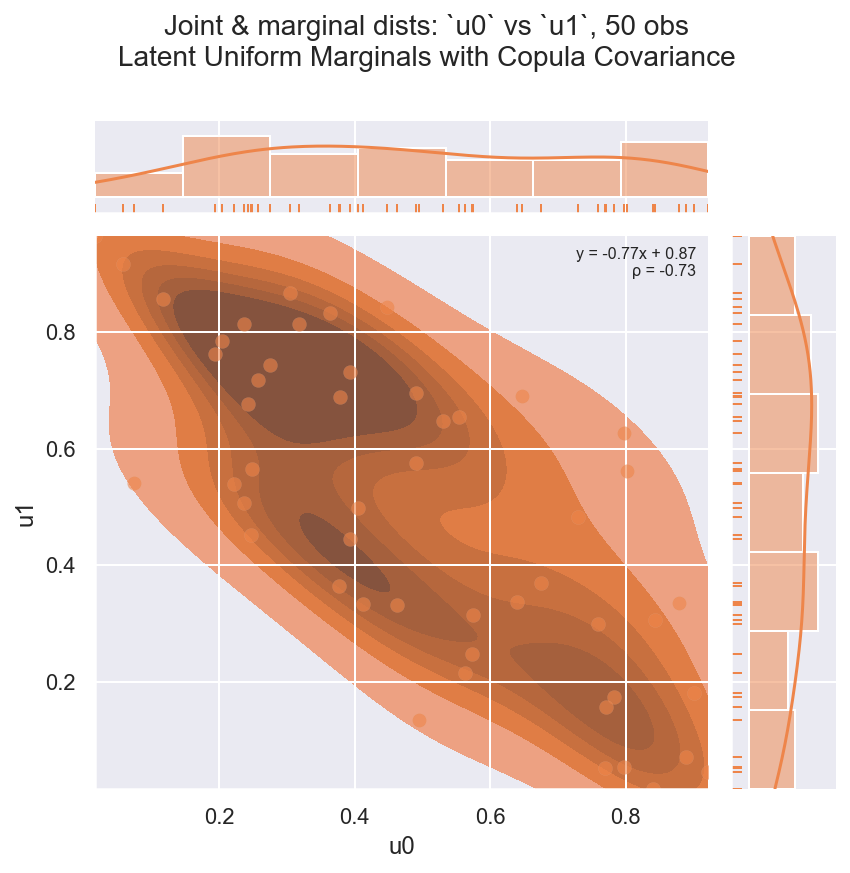

In [9]:
f = eda.plot_joint_numeric(data=df_train, ft0='u0', ft1='u1', kind='kde+scatter', colori=1, 
        txtadd='Latent Uniform Marginals with Copula Covariance')

**Observe:**

+ Now the marginals are uniform, but the correlation remains

### 1.2.3 View the Observed Marginals `m0`, `m1` (post transformation)

In this forward-pass to create the synthetic data, next we pass each dimension of the Latent Uniform $U$ through the 
Inverse CDF of the marginal distribution $\Phi^{-1}_{\mathfrak{M}}$ to get the Marginal distribution(s) in $M$

$$
\begin{aligned}
(M_{0}, M_{1}) &= \Phi^{-1}_{\mathfrak{M}}(U_{0}, U_{1}) \\
                &= \text{LogNormalInvCDF}(U_{0}, U_{1})
\end{aligned}
$$

The marginal distribution(s) $M$ can be anything. In practice we tend to use right-tailed distributions in the 
Exponential family, here a LogNormal. We can, of course, use different distributions on each marginal - there's no 
constraint to be the same - but we use the same ones here. This is the data that we would observe in the 
real-world dataset:

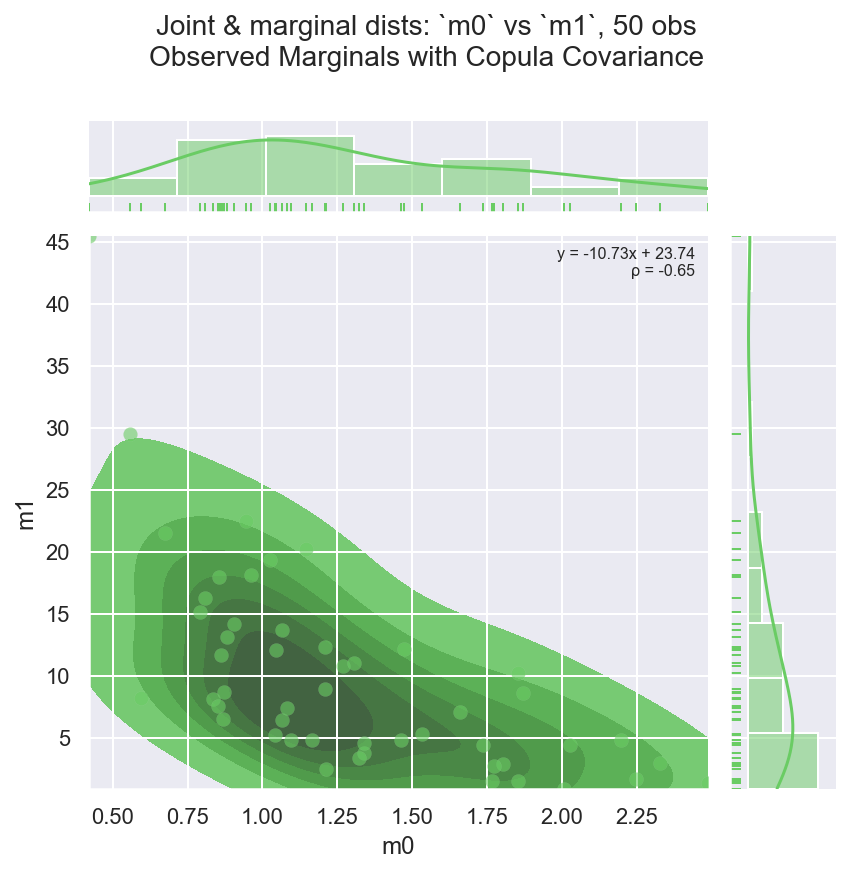

In [10]:
f = eda.plot_joint_numeric(data=df_train, ft0='m0', ft1='m1', kind='kde+scatter', colori=2, 
            txtadd='Observed Marginals with Copula Covariance')
fqn = figio.write(f, fn='000_jointplot_corr')

**Observe**

+ Marginals now have unique long-tail distributions, and the correlation remains

### 1.2.4 View the Marginals $Mx$ if they were synthesized without a Copula

In project class `synthetic.create_copula.CopulaBuilder` we also synthesize uncorrelated observations using the same
transformation and final marginals $M$, so that we can visually compare the different effects. 

$$
\begin{aligned}
(C^{\chi}_{0}, C^{\chi}_{1}) &\sim \text{Normal}(\mu, \sigma, \text{shape}=2) \\
(U^{\chi}_{0}, U^{\chi}_{1}) &= \text{NormalCDF}(C^{\chi}_{0}, C^{\chi}_{1}) \\
(M^{\chi}_{0}, M^{\chi}_{1}) &= \text{LogNormalInvCDF}(U^{\chi}_{0}, U^{\chi}_{1}) \\
\end{aligned}
$$

Uncorrelated marginals $M^{\chi}$ individually look the same as $M$. We have to look at the joint distribution to see the difference

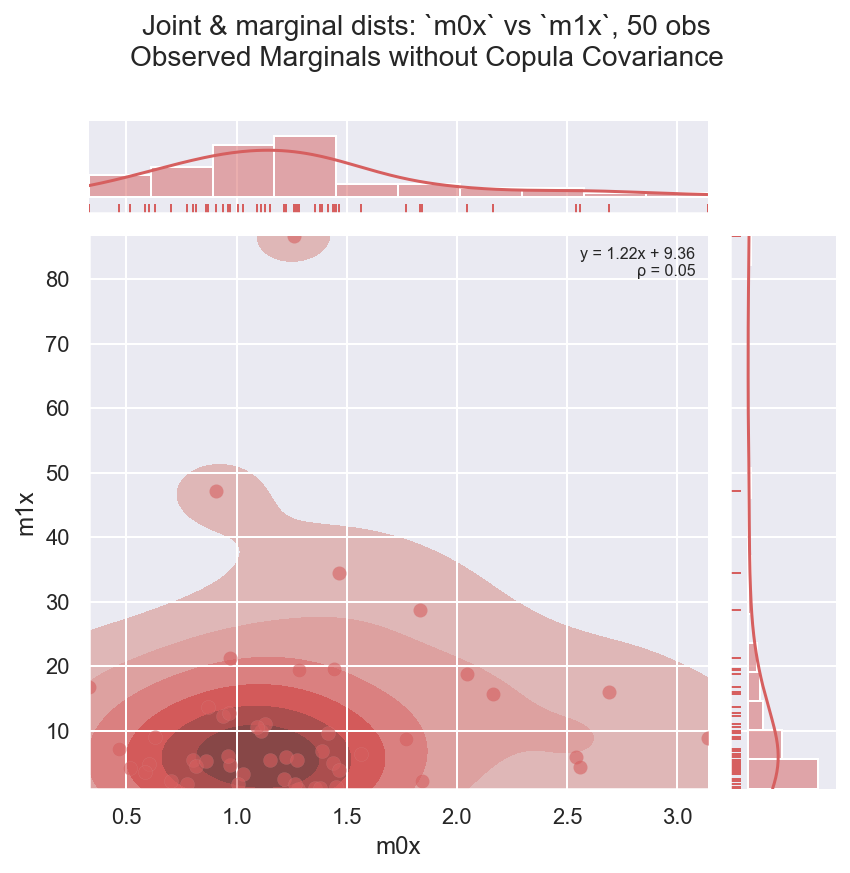

In [11]:
f = eda.plot_joint_numeric(data=df_train, ft0='m0x', ft1='m1x', kind='kde+scatter', colori=3, 
            txtadd='Observed Marginals without Copula Covariance')

**Observe**

+ Spherical joint distribution, no correlation between our marginals here

### 1.2.5 Overplot Marginals Correlated ($M$) vs Uncorrelated ($M^{\chi}$) to Highlight the Differences

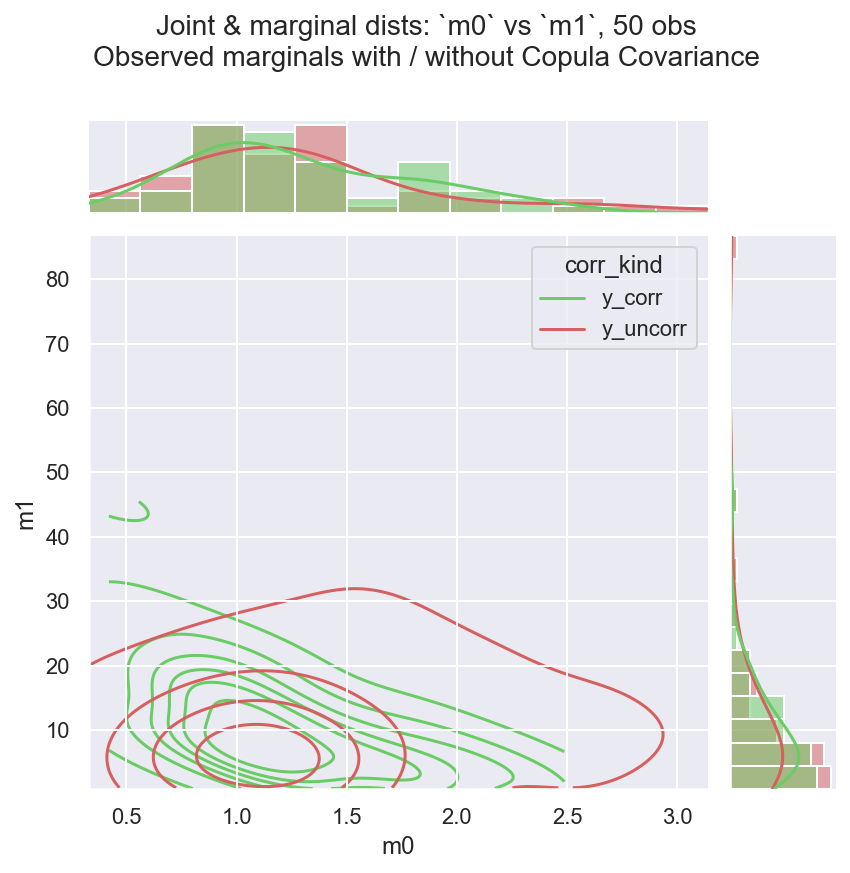

In [12]:
dfp = pd.concat((df_train[['m0', 'm1']], df_train[['m0x', 'm1x']]\
                 .rename(columns={'m0x':'m0', 'm1x': 'm1'})),
                axis=0, ignore_index=True)
dfp['corr_kind'] = np.repeat(['y_corr', 'y_uncorr'], repeats=len(df_train))
f = eda.plot_joint_numeric(
    data=dfp, ft0='m0', ft1='m1', hue='corr_kind', kind='kde', kdefill=False, colori=2,
    txtadd='Observed marginals with / without Copula Covariance')
fqn = figio.write(f, fn='000_jointplot_corr_vs_uncorr')

**Observe**

+ The marginals look almost identical, but the joint distribution is very different
+ We might say _"so what?"_ because we can always jointplot our marginals $M$ and see that there is correlation
+ The huge impact is that these lead to a very different **joint product** $y$...

## 1.3 Compare the Impact on Joint Product $y$

If we build a model $\mathcal{H}$ that fits to marginals $M$, but does not account for the correlation, $\mathcal{H}$
will behave as if we fit it on uncorrelated marginals $M^{\chi}$. The predicted differences in $M$ and $M^{\chi}$ won't 
look too different on the marginals, but the joint products $y = M_{0} \cdot M_{1}$ vs 
$y^{\chi} = M^{\chi}_{0} \cdot M^{\chi}_{1}$ can become very different:

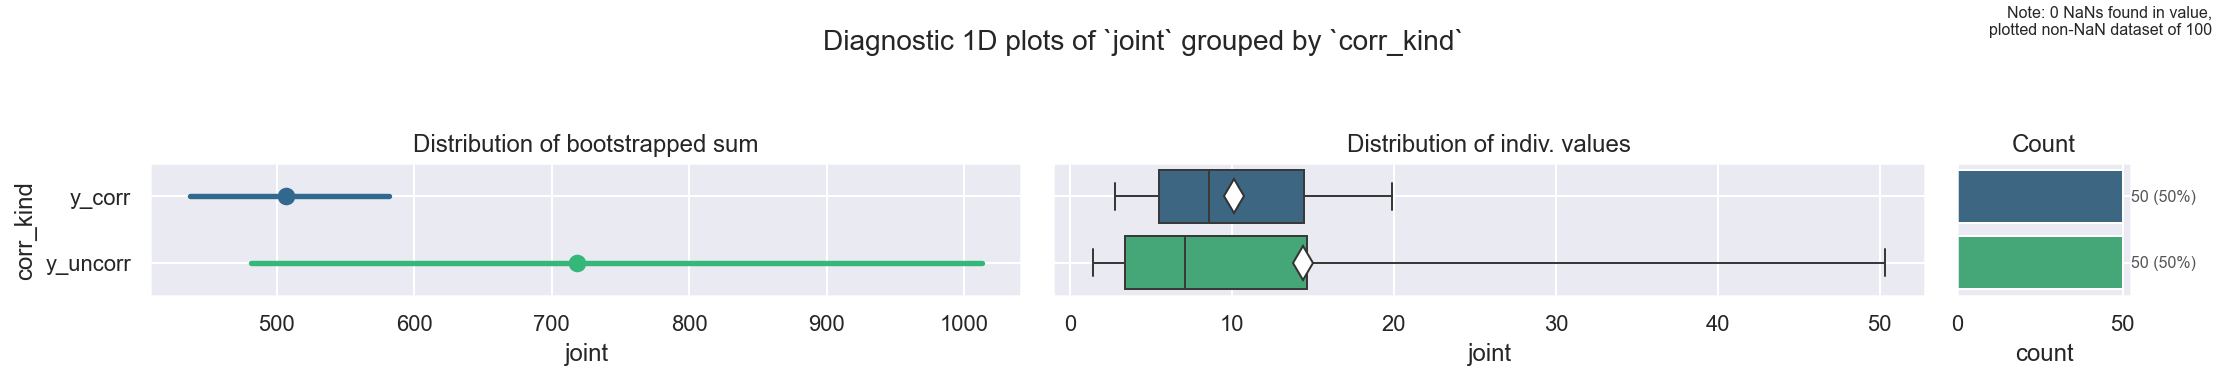

In [13]:
dfp['joint'] = dfp[['m0', 'm1']].product(axis=1)
pal = sns.color_palette(['C2', 'C3'])
f = eda.plot_smrystat_grp(dfp, grp='corr_kind', val='joint', palette=pal, plot_outliers=False)
fqn = figio.write(f, fn='000_y_corr_vs_uncorr')

**Observe:**

+ This customer diagnostic combination plot shows: 
  + Pointplot (left): The [bootstrapped](https://sedar.co/posts/bootstrap-primer/) sums $\sum_{i}y_{i}$ vs $\sum_{i}y^{\chi}_{i}$
  + Boxplot (center): The individual values $y_{i}$ vs $y^{\chi}_{i}$
  + Countplot (right): The counts of observations $i$
+ The (bootstrapped) sum of `y_uncorr` ($\mu \approx 700$) is almost always much higher than for `y_corr` ($\mu \approx 500$)
+ This shows that if our model $\mathcal{H}$ were to estimate marginals correctly but ignore the covariance, it would erroneously mis-estimate the joint distribution total value $y$. Here that mistake is to overestimate.

#### View the overestimate $\delta = \sum_{i}y^{\chi}_{i} - \sum_{i}y_{i}$

Let's view the bootstapped overestimate `delta = y_uncorr = y_corr`

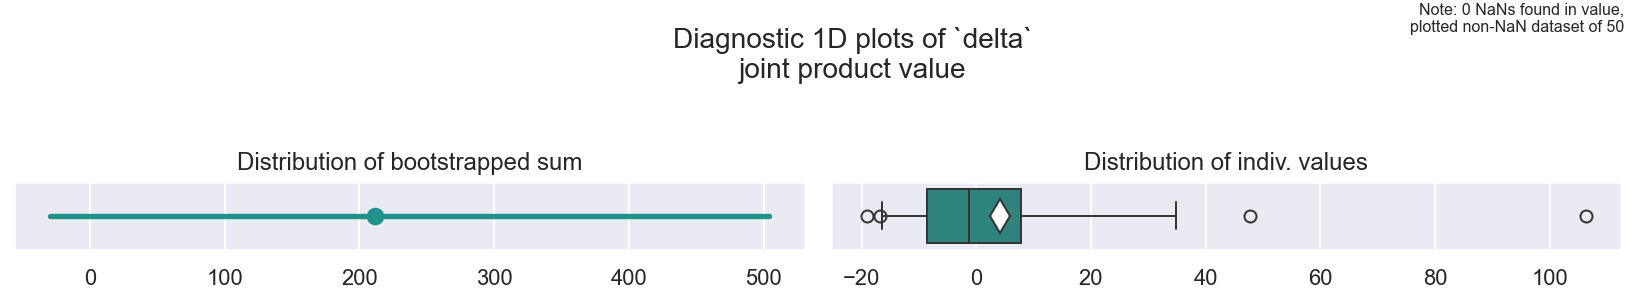

In [14]:
idx = dfp['corr_kind'] == 'y_corr'
dfpp = pd.DataFrame({'delta': dfp.loc[~idx, 'joint'].values - dfp.loc[idx, 'joint'].values}, index=df_train.index)
g = eda.plot_smrystat(dfpp, val='delta', txtadd='joint product value', plot_outliers=False)
fqn = figio.write(f, fn='000_y_delta')

**Observe:**

If we imagine this to be a portfolio of $50$ policies, and the value of interest is an Expected Loss Cost 
$y == \mathbb{E}_{\text{loss}}$, and the units are dollars, then: 
+ If we were to use a model that ignores covariance, we might get a portfolio estimate of $\mathbb{E}_{loss} \approx 200$ dollars 
  **higher** than if we were to use a better model that handles covariance with a copula function
+ This overestimate is a substantial $\frac{700}{500} \approx \mathbb{+40\%}$ and would likely make the difference between profitable 
  pricing / accurate reserving, or greatly loss-making business over the portfolio.

---

---

# 2. Brief Technical Summary: The Copula Model designed in this Project

Again, this **Intro** is for verbal presentation and discussion purposes only - ideally followed by a deeper technical 
walkthrough of the project in a long-form style. Because this project is a reference, it contains huge amounts of detail 
which is not worthwhile to summarise too much. 

The interested reader should refer to the project notebooks where state the architecture in full, we evaluate the 
behaviour and performance of the models in a consistent Bayesian workflow, including several state-of-the-art methods
unavailable to conventional max-likelihood / machine-learning models.

Here we can can highlight a very tangible impact of our results of using a Copula model (`ModelA2`) vs a Naive model 
(`ModelA0`)

## 2.1 Brief Orientation on Model Workflow and Architecture

### General Approach

+ We create a synthetic dataset with 60 observations: these have exogenous values on 2 marginals $M_{0}$, $M_{1}$
+ We create 3 models of increasing sophistication to estimate $\hat{M_{0}}$, $\hat{M_{1}}$ and thus the joint product 
  $\hat{y} = \hat{M_{0}} \cdot \hat{M_{1}}$
+ The simplest naive model (`ModelA0`) does not include a copula function, and the most sophisticated model `ModelA2` does


+ We define a training set of 50 random observations, fit the models, and view the forecasted predictions on a holdout 
  set of 10 observations
+ We fully evaluate the models in the project notebooks using a variety of sophisticated techniques including In-sample
  Prior & Posterior Retrodictive ECDF plots, LOO-PIT calculations & plots, and more convential coverage, RSME and R2 
  calculations. This forecast on the holdout is _not_ a formal model evaluation
+ However for discussion and elucidation we can plot the [bootstrapped](https://sedar.co/posts/bootstrap-primer/) sum
  of the actual values $\sum{y}_{\text{holdout}}$ and compare to the posterior predictions $\sum{\hat{y}}_{\text{holdout}}$
  of the two models 

### General Architecture

In contrast to the "forward-pass" that we use to synthesize the data, for the model we must of course start with the 
only data that we have (the observed marginals $M$) and work in a "backwards-pass" toward the copula.

1. Define 2 marginal distributions $(\mathfrak{M}_{0}, \mathfrak{M}_{1})$ (here for convenience we use the same family 
   (Lognormals) for each, so we will represent as simply $\mathfrak{M}$). Each marginal is parameterised by a linear 
   submodel $\beta^{T}\mathbb{x}_{ij}$ to allow linear regression onto selected features $j$ 
$$\mathfrak{M} = \text{LogNormal}(\mu=\beta^{T}\mathbb{x}_{ij}, \sigma)$$
   
2. Transform each dimension of the observed marginal data $M$ through the CDF of the marginal distribution(s) to yield 
   data distributed according to a Latent Uniform distribution $U$
$$(U_{0}, U_{1}) = \Phi_{\mathfrak{M}}(M_{0}, M_{1})$$

3. Transform each dimension of now-uniform data $U$ through the Inverse CDF of the copula distribution(s) 
   $(\mathfrak{C}_{0}, \mathfrak{C}_{1})$ (here for convenience we use the same family (Normal aka a Gaussian Copula) 
   for each, so we will represent as simply $\mathfrak{C}$)
$$(C_{0}, C_{1}) = \Phi^{-1}_{\mathfrak{C}}(U_{0}, U_{1})$$

4. Evidence the transformed data $C$ against the copula function $\log \mathcal{L}\ \mathfrak{C}$ 
5. For stability and correctness, we also evidence at the marginals and minimise a Jacobian adjustment on the 
   double-transformed data.
6.  **Importantly**, and unlike other model specifications in the Bayesian literature, we preserve the full posterior
   distribution(s) all the way through the model specification, without ever having to collapse to point estimates



### Plate Notation Diagram

Refer to Notebook `102_ModelA2.ipynb` and project class `models.copula.ModelA2` for the full details. Here we will just
show the plate notation of the model.

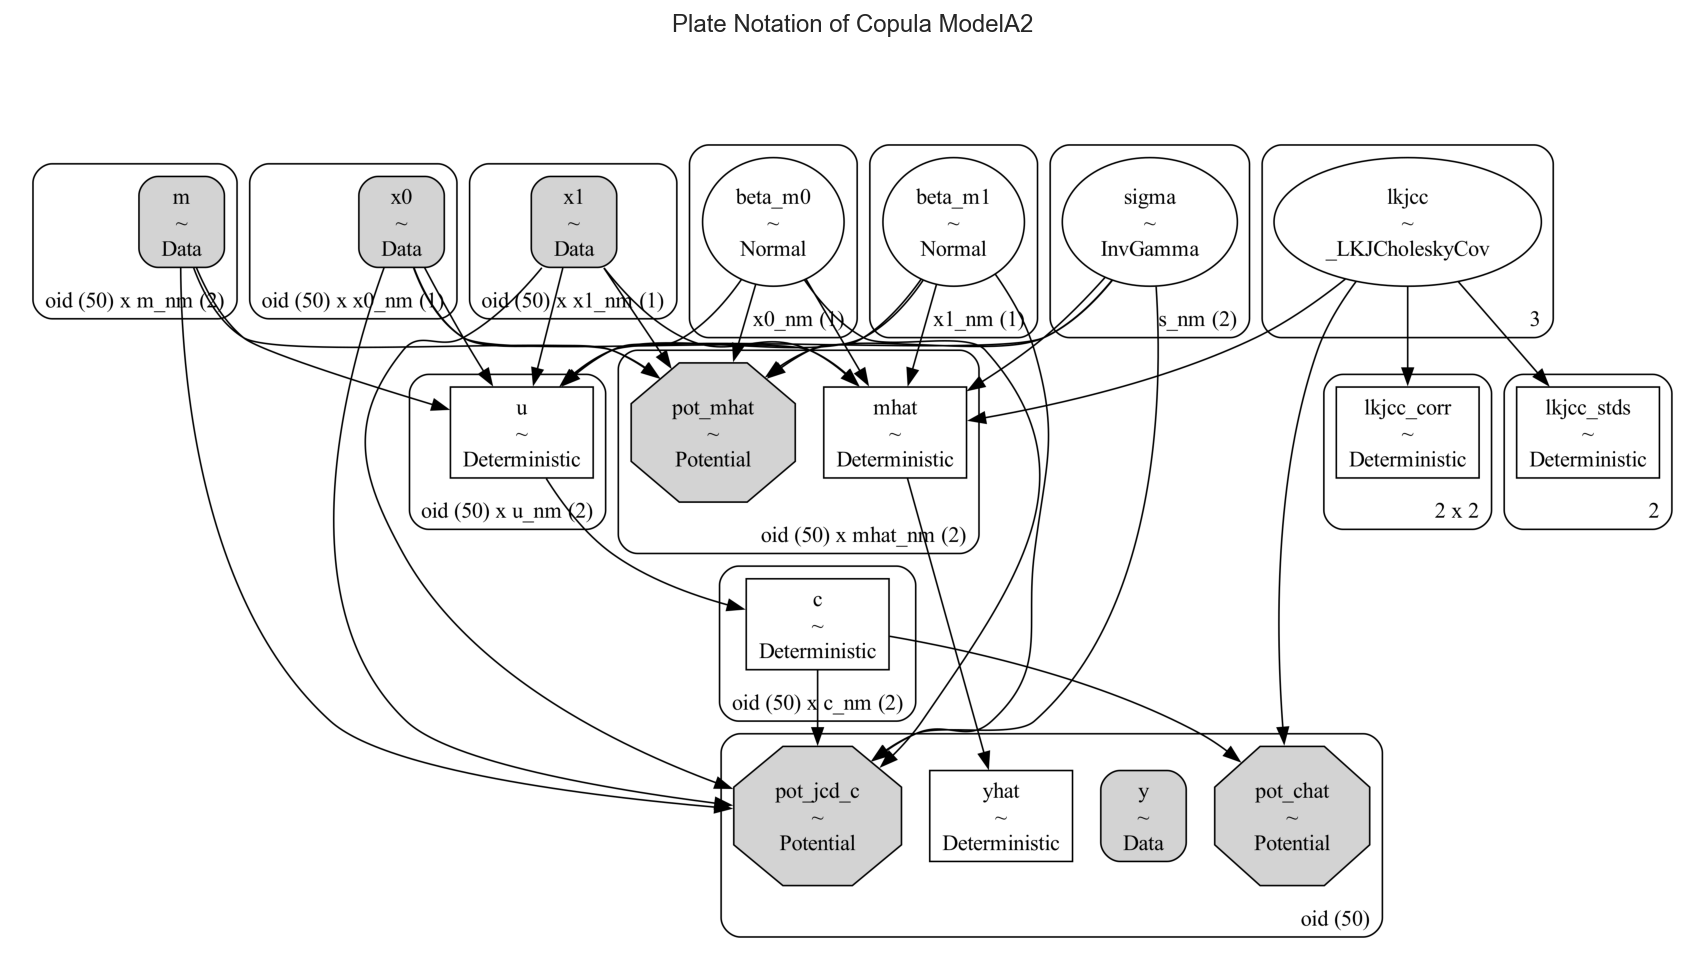

In [15]:
figio.read(fn='../data/models/graph_mdla2_v120_dfx_train.png', 
        title='Plate Notation of Copula ModelA2', figsize=(12, 7))

**Observe:**

This advanced, fully Bayesian architecture allows for:
+ Regression via linear submodels $\beta^{T}\mathbf{x}$ on the marginals of `mhat`
+ Efficient covariance via an $\text{LKJCholeskyCovariance}$ structure
+ A natural transformation from `M -> U -> C` including Jacobian Adjustment

## 2.2 Compare Estimated $\hat{y}$ `ModelA0` vs `ModelA2`

### `ModelA0`

This model sets a baseline for performance: it uses the same marginals but does not have a copula. This is
"the best that one could do" with a naive non-copula architecture, and the performance / results are analogous to 
$M^{\chi}$ that we discussed in $\S1$

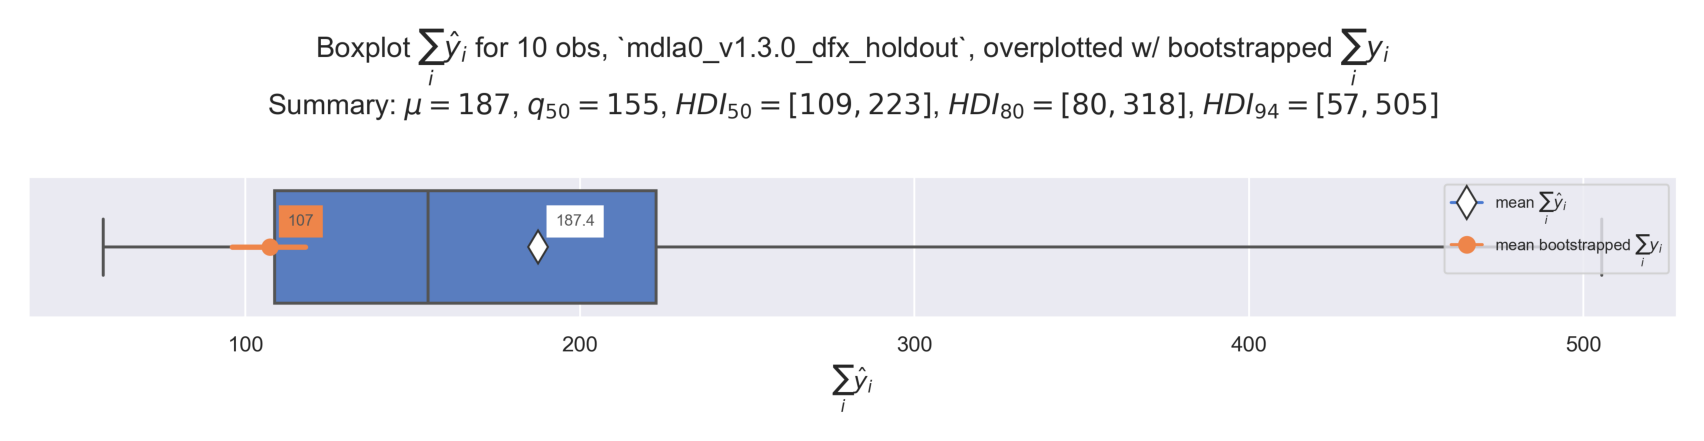

In [16]:
figio.read(fn='100_2_8_4_ppc_holdout_y_boxplot_mdla0_v1_3_0_dfx_holdout.png', figsize=(12, 6))

**Observe:**

+ Now we can clearly see the impact: although the in-sample model fit was acceptable, the combined value $y$ is way
  off, because this model ignores copula correlation between the marginals
+ The mean of $\sum_{i}{\hat{y}}_{i}$ is $\mu = 133$, is very different (and sits outside of) the bootstrapped sum of 
  the actual data $\sum_{i}{\hat{y}}_{i}$ which has a mean $\mu = 96$
+ Comparing means we have a $\frac{133}{96} \approx 39\%$ overestimate!
+ We do see that the PPC distribution envelops the bootstrapped actual data, which is promising, and means the model 
  wouldn't necessarily be wrong to use, but there is clearly room to improve!

### `ModelA2`

This is our most advanced model with a copula architecture: the performance / results are analogous to 
$M$ that we discussed in $\S1$

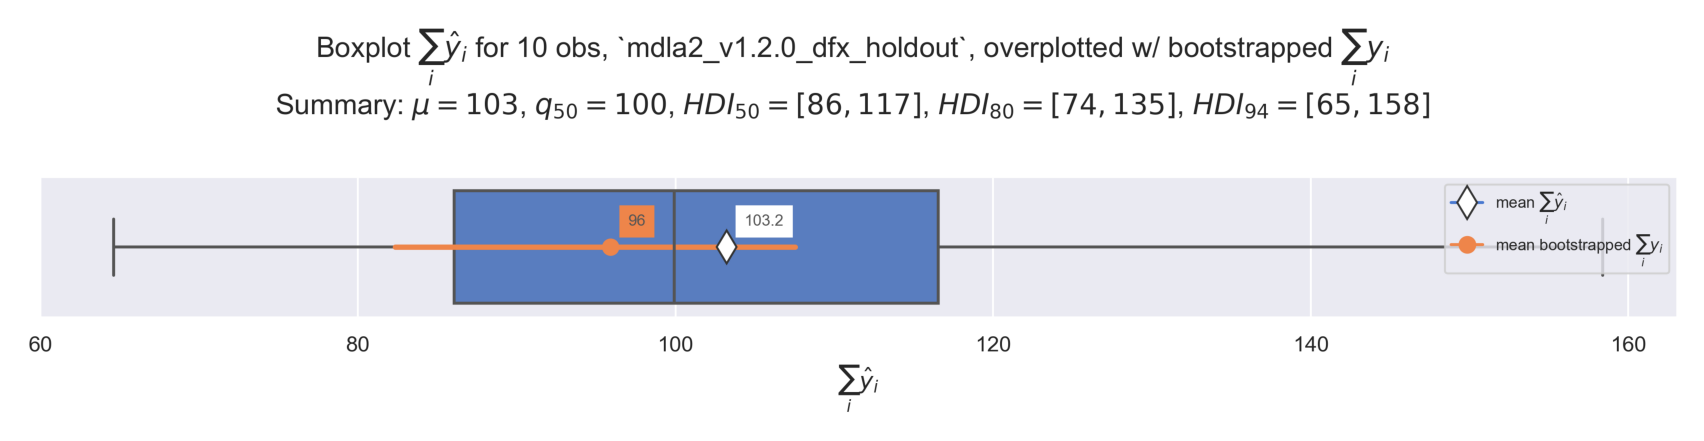

In [17]:
figio.read(fn='102_2_8_4_ppc_holdout_y_boxplot_mdla2_v1_2_0_dfx_holdout.png', figsize=(12, 6))

**Observe:**

+ Now we can clearly see the impact: the Jacobian adjustment has allowed `mdla2` to estimate a much more precise and 
  accurate value for $\hat{y}$
+ The mean of $\sum_{i}{\hat{y}}_{i}$ is $\mu = 103$, and falls within the bootstrapped sum for the actual data $\sum_{i}{\hat{y}}_{i}$
  which has a mean $\mu = 96$
+ Comparing means, we get $\frac{103}{96} \approx 7\%$ overestimate
+ This is substantially better than `mdla0`, and also meaningfully improves on `mdla1`

### `ModelA2` vs `ModelA0`

In the above, we see a reduction in the mean overestimate of $y$ from $39\%$ down to $7\%$: **a 32 percentage point drop**

This is a **huge difference** on this very small and simple dataset, and found only by correctly modelling the covariance 
using a copula and a sophisticated model architecture.

## 2.3 Supercharged Predictions with Quantified Uncertainty: Exceedance Curve

Now we pull back to demonstrate the power and utility of using a Bayesian model in the first place: because the predicted
output values individually & jointly have **quantified uncertainty** aka empirical probability. We can sum these and 
create an **Exceedance Curve (1 - ECDF)**

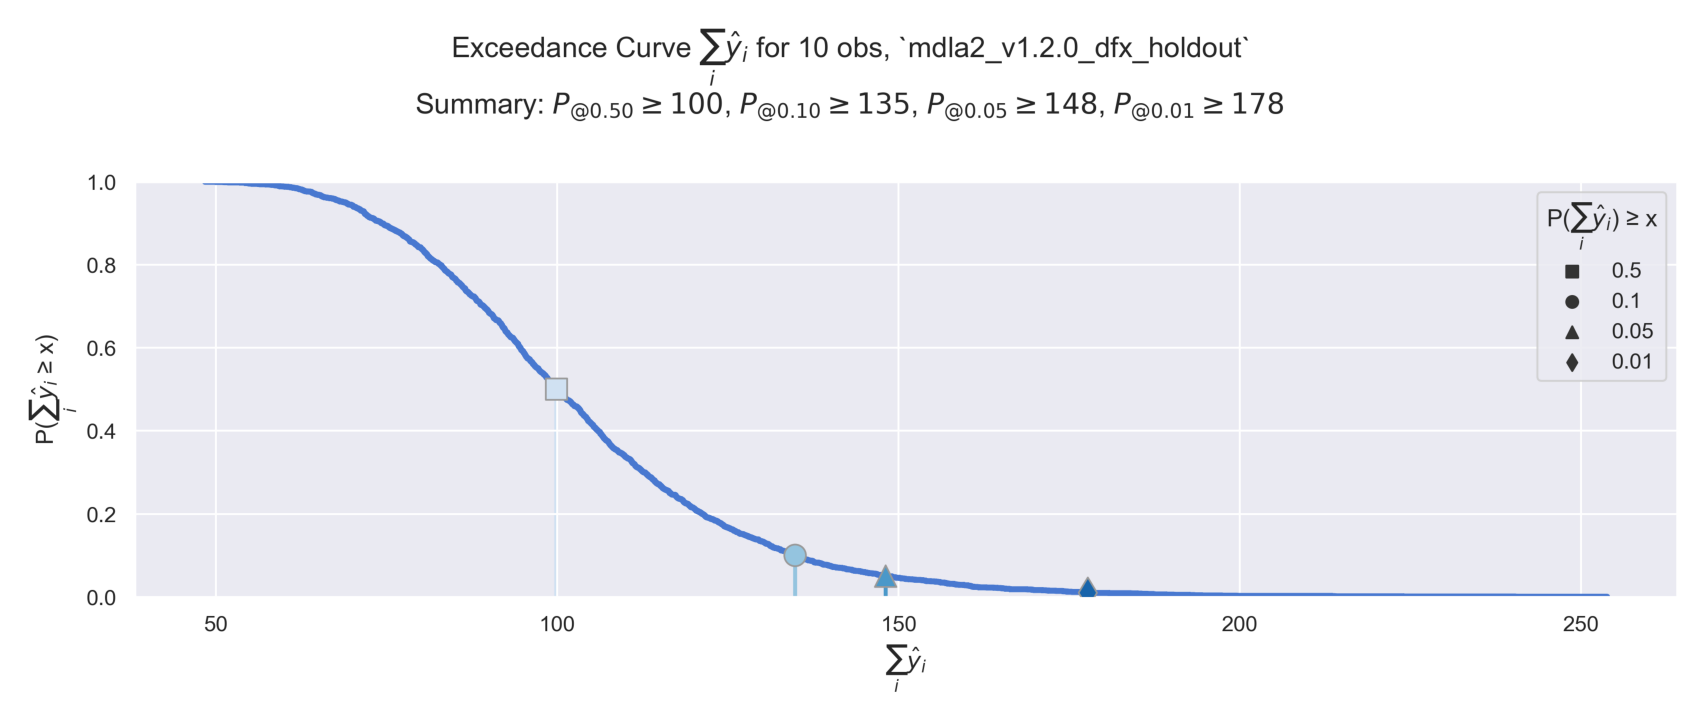

In [18]:
figio.read(fn='102_2_8_4_ppc_holdout_y_exceedance_mdla2_v1_2_0_dfx_holdout.png', figsize=(12, 6))

We can read this curve _vertically_ to determine the empirical probability of achieving a particular value $y$:
+ $P(\sum{\hat{y}_{i}} > 150) \lt 0.05$: i.e. if we're worried about $\sum{\hat{y}_{i}} > 150$, we can slightly relax 
  because the probability is less than 1-in-20
+ $P(\sum{\hat{y}_{i}} > 200) \lt 0.01$: i.e. if we're worried about $\sum{\hat{y}_{i}} > 200$, we can relax 
  because the probability is less than 1-in-100

We can read this curve _horizontally_ to determine the value $y$ at a particular probability:
+ $P_{@0.5} \geq 100$: i.e. 50% of all outcomes occur at $\sum{\hat{y}_{i}} \leq 100$
+ $P_{@0.01} \geq 178$: i.e. 99% of all outcomes occur at $\sum{\hat{y}_{i}} \leq 178$
  

---

---

# Notes

In [19]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv

Author: jonathan.sedar@oreum.io

Last updated: 2025-01-24 17:25:19

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pyprojroot: 0.3.0
numpy     : 1.26.4
sys       : 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:19:53) [Clang 18.1.8 ]
oreum_core: 0.10.0
seaborn   : 0.13.2
pandas    : 2.2.3



### Next Steps

Now the interested reader should dig into the Notebooks in project reference
[`oreum_copula`](https://github.com/oreum-industries/oreum_copula)

There we demonstrate the full E2E workflow for models of increasing sophistication, 
including several state-of-the-art methods unavailable to conventional 
max-likelihood / machine-learning models.

+ `100_ModelA0.ipynb`: Core (naive) architecture: Create priors, marginal likelihoods, but no copula
+ `101_ModelA1.ipynb`: Partial architecture (extends ModelA0): Include Gaussian copula (w/ Jacobian adjustment), and several technical innovations to let `pymc` work with the transformations
+ `102_ModelA2.ipynb`: Full architecture (extends ModelA1): Include Jacobian Adjustment on transformed observations

<a href='https://oreum.io'><img src='../assets/img/Oreum_wordmark_black_right_aligned_S.png' width='300px' style="float: right;"/></a><div style="clear:both"/>

---
**[Oreum Industries](https://oreum.io/) &copy; 2024**